## HW2: Linear Discriminant Analysis
In hw2, you need to implement Fisher’s linear discriminant by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data
Please note that only NUMPY can be used to implement your model, you will get zero point by simply calling sklearn.discriminant_analysis.LinearDiscriminantAnalysis

## Load data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

In [4]:
x_train, x_test, y_train, y_test = np.load('classification_data.npy', allow_pickle=True)

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3750, 2)
(3750,)
(1250, 2)
(1250,)


## 1. Compute the mean vectors mi, (i=1,2) of each 2 classes

In [6]:
# m1, m2 are the mean vector for class 1 and 2

# m1 = (1/N1)*sum(x in C1), N1 = the number of points in C1
# m2 = (1/N2)*sum(x in C2), N2 = the number of points in C2
m1 = np.mean(x_train[y_train == 0], axis = 0)
m2 = np.mean(x_train[y_train == 1], axis = 0)

# I also changed the shape of mean vectors to make it ready 
# for matrix multiplication later
m1 = m1.reshape(1, x_train.shape[1])
m2 = m2.reshape(1, x_train.shape[1])

In [7]:
print(f"mean vector of class 1: {m1}", f"mean vector of class 2: {m2}")

mean vector of class 1: [[ 0.99253136 -0.99115481]] mean vector of class 2: [[-0.9888012   1.00522778]]


## 2. Compute the Within-class scatter matrix SW

In [8]:
# SW is the within-class covariance matrix
# SW = sum((x-m1)·(x-m1).T, x in C1) + sum((x-m2)·(x-m2).T, x in C2)

# first, we separate the data into class 1 and 2
x1 = x_train[y_train == 0]
x2 = x_train[y_train == 1]

# SW = sum((x-m1).T·(x-m1), x in C1) + sum((x-m2).T·(x-m2), x in C2)
# I changed the order of transpose to make the shape consistent
SW = np.dot((x1 - m1).T, (x1 - m1)) + np.dot((x2 - m2).T, (x2 - m2))

In [9]:
print(f"Within-class scatter matrix SW: {SW}")

Within-class scatter matrix SW: [[ 4337.38546493 -1795.55656547]
 [-1795.55656547  2834.75834886]]


## 3. Compute the Between-class scatter matrix SB

In [10]:
# SB is the between-class covariance matrix
# SB = (m2 - m1)·(m2 - m1).T
# I changed the order the transpose to make the shape consistent

SB = np.dot((m2 - m1).T, (m2 - m1))

In [11]:
print(f"Between-class scatter matrix SB: {SB}")

Between-class scatter matrix SB: [[ 3.92567873 -3.95549783]
 [-3.95549783  3.98554344]]


## 4. Compute the Fisher’s linear discriminant

In [12]:
# The optimal W is the eigenvector of inv(SW)·SB that corresponds to 
# the largest eigenvalue 

# compute inv(SW)·SB
inv_SW = np.linalg.inv(SW)
A = np.dot(inv_SW, SB)

# get eigenvalue and eigenvector
eigenvalue, eigenvector = np.linalg.eig(A)

# the optimal W is the eigenvector corresponds to the largest eigenvalue 
max_eigenvalue_index = np.argmax(eigenvector)
W = eigenvector[:, max_eigenvalue_index]
W = W.reshape(W.shape[0], 1) # reshape into n*1

In [13]:
print(f" Fisher’s linear discriminant: {W}")

 Fisher’s linear discriminant: [[ 0.37003809]
 [-0.92901658]]


## 5. Project the test data by linear discriminant and get the class prediction by K nearest-neighbor rule. Please report the accuracy score with K values from 1 to 5
you can use accuracy_score function from sklearn.metric.accuracy_score

In [17]:
def Predict(x_train, x_test, y_train, y_test, w):
    x_train_proj = np.dot(x_train, w)
    x_test_proj = np.dot(x_test, w)
    y_pred = np.zeros((len(y_test),1))
    
    for k in range(1, 6):
        for test_proj in x_test_proj:
            Distance = abs(np.subtract(x_train_proj, test_proj))
            MinK = np.sort(Distance, axis=0)[:k]
            Pred = 0
            for x in range(k):
                MinK_at = np.where(Distance==MinK[x])[0]
                Pred += y_train[MinK_at]
            y_pred[np.where(x_test_proj==test_proj)[0]] = (Pred > k/2)
        # Part5:
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy of test-set {acc}")

In [18]:
Predict(x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, w=W)

Accuracy of test-set 0.8488
Accuracy of test-set 0.8704
Accuracy of test-set 0.8792
Accuracy of test-set 0.8824
Accuracy of test-set 0.8912


## 6. Plot the 1) best projection line on the training data and show the slope and intercept on the title (you can choose any value of intercept for better visualization) 2) colorize the data with each class 3) project all data points on your projection line. Your result should look like this image

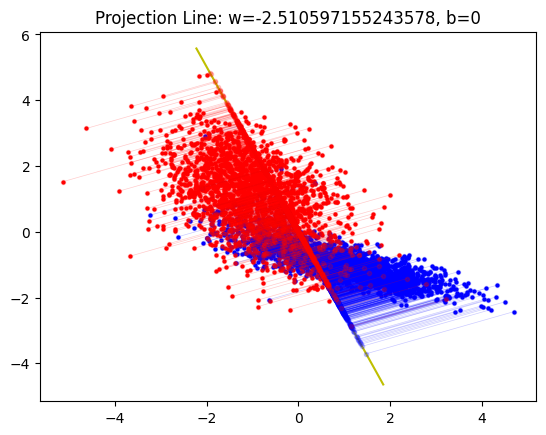

In [20]:
def PlotResult(Bias, MarkerSize, Alpha, LineWidth, Group1, Group2, weight):
    plt.title(f'Projection Line: w={(weight[1]/weight[0])[0]}, b={Bias}')
    plt.plot([-6*weight[0], 5*weight[0]], [-6*weight[1], 5*weight[1]], 'y-')
    plt.scatter(Group1[:, 0], Group1[:, 1], c='b', s=MarkerSize)
    plt.scatter(Group2[:, 0], Group2[:, 1], c='r', s=MarkerSize)
    r = weight.reshape(2,)
    r2 = np.linalg.norm(r)**2
    for pt in Group1:
        prj = r * r.dot(pt) / r2
        plt.plot([prj[0], pt[0]], [prj[1], pt[1]], marker='.', linestyle='-', color='b', alpha=Alpha, linewidth=LineWidth)
    for pt in Group2:
        prj = r * r.dot(pt) / r2
        plt.plot([prj[0], pt[0]], [prj[1], pt[1]], marker='.', linestyle='-', color='r', alpha=Alpha, linewidth=LineWidth)
    plt.savefig('FLD_ProjectionResult.jpg')
    plt.show()
# Plotting Result
Group1 = x_train[y_train == 0]
Group2 = x_train[y_train == 1]
PlotResult(Bias=0, MarkerSize=4, Alpha=0.2, LineWidth=0.5, Group1=Group1, Group2=Group2, weight=W)